# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.36 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [6]:
from ddpg_agent import Agent
from collections import deque
import pandas as pd
import torch

import matplotlib.pyplot as plt
from workspace_utils import active_session

In [7]:
m_agents = Agent(state_size = state_size, action_size = action_size, n_agents=2, random_seed = 0)

In [8]:
def save_checkpoint(file='checkpoint.pt'):
    """ Save the model """
    checkpoint = {
        'actor_dict': m_agents.actor_local.state_dict(),
        'critic_dict': m_agents.critic_local.state_dict()
        }
    print('\nSaving model ...', end=' ')
    torch.save(checkpoint, file)
    print('done.')

In [9]:
def ddpg(n_episodes=3000, checkpoint_file='checkpoint.pt', n_agents = 2, print_every=100, max_t=1000):
        """Deep Deterministic Policy Gradients (DDPG).
        Params
        ======
            n_episodes (int): maximum number of training episodes
            checkpoint_file(str): model file
        """  
        
        scores_deque = deque(maxlen=100)
        scores_all = []

        for i_episode in range(1, n_episodes+1):

            env_info = env.reset(train_mode=True)[brain_name]      
            states = env_info.vector_observations                  
            scores = np.zeros(n_agents)                            

            m_agents.reset()                                       

#             for t in range(max_t):
            while True:
                actions = m_agents.act(states)                     
                env_info = env.step(actions)[brain_name]           
                next_states = env_info.vector_observations         
                rewards = env_info.rewards                         
                dones = env_info.local_done 
                
                m_agents.step(states, actions, rewards, next_states, dones)
                states = next_states
                scores += rewards
            
                if any(dones):
                    break

            score = np.max(scores)                                 # take max of agent scores
            scores_deque.append(score)
            score_average = np.mean(scores_deque)
            scores_all.append(score)

            print('\rEpisode {}, Average Score: {:.2f}, Max: {:.2f}, Min: {:.2f}, Avg: {:.2f}'\
                  .format(i_episode, score_average, 
                          np.max(scores_all[-print_every:]), 
                          np.min(scores_all[-print_every:]), 
                          np.mean(scores_all[-print_every:])), end="") 
            
            # Every n episodes print score
            if i_episode % print_every == 0:
                print('\rEpisode {}, Average Score: {:.2f}, Max: {:.2f}, Min: {:.2f}, Avg: {:.2f}'\
                  .format(i_episode, score_average, 
                          np.max(scores_all[-print_every:]), 
                          np.min(scores_all[-print_every:]), 
                          np.mean(scores_all[-print_every:])))        

            # The environment is considered solved, 
            # when the scores average (over 100 episodes) is at least +0.5.
            if score_average >= 0.5:
                print('\n\nEnvironment solved in {:d} episodes!\t' \
                  'Average Score: {:.3f}'
                  .format(i_episode, score_average))
                save_checkpoint(checkpoint_file)                
                break            

        return scores_all       

In [10]:
with active_session():
    # do long-running work here
    scores_all = ddpg()

Episode 100, Average Score: 0.00, Max: 0.10, Min: 0.00, Avg: 0.00
Episode 200, Average Score: 0.00, Max: 0.10, Min: 0.00, Avg: 0.00
Episode 300, Average Score: 0.00, Max: 0.00, Min: 0.00, Avg: 0.00
Episode 400, Average Score: 0.03, Max: 0.20, Min: 0.00, Avg: 0.03
Episode 500, Average Score: 0.00, Max: 0.09, Min: 0.00, Avg: 0.00
Episode 600, Average Score: 0.00, Max: 0.00, Min: 0.00, Avg: 0.00
Episode 700, Average Score: 0.00, Max: 0.09, Min: 0.00, Avg: 0.00
Episode 800, Average Score: 0.02, Max: 0.20, Min: 0.00, Avg: 0.02
Episode 900, Average Score: 0.11, Max: 0.60, Min: 0.00, Avg: 0.11
Episode 1000, Average Score: 0.33, Max: 2.60, Min: 0.00, Avg: 0.33
Episode 1100, Average Score: 0.34, Max: 1.50, Min: 0.00, Avg: 0.34
Episode 1200, Average Score: 0.37, Max: 2.10, Min: 0.00, Avg: 0.37
Episode 1300, Average Score: 0.48, Max: 2.60, Min: 0.00, Avg: 0.48
Episode 1348, Average Score: 0.51, Max: 2.50, Min: 0.00, Avg: 0.51

Environment solved in 1348 episodes!	Average Score: 0.509

Saving mode

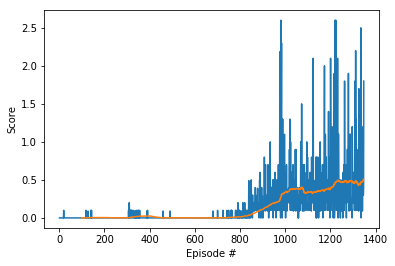

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_all)+1), scores_all)

rolling_window = 100
rolling_mean = pd.Series(scores_all).rolling(rolling_window).mean()
plt.plot(rolling_mean);

plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
env.close()

When finished, you can close the environment.